In [1]:
; cl-waffeを読み込む
(load "../../cl-waffe.asd")
; kfttを読み込むための自作ライブラリ
(load "../../examples/kftt-data-parser.lisp")
(ql:quickload `(:clgplot :cl-waffe) :silent t)

T

T

(:CLGPLOT :CL-WAFFE)

SB-INT:SIMPLE-STYLE-WARNING: undefined function: KFTT-DATA-PARSER::REGISTER-WORD
SB-INT:SIMPLE-STYLE-WARNING: undefined function: KFTT-DATA-PARSER:CALC-DATA-SIZE
SB-INT:SIMPLE-STYLE-WARNING: undefined function: KFTT-DATA-PARSER:CALC-MAX-LENGTH


Unable to find framework CUDA


## Seq2Seqを用いてKFTTを学習

cl-waffeのRNNを用いて[京都フリー翻訳タスク (KFTT)](http://www.phontron.com/kftt/index-ja.html#leaders)を学習させる例です。

学習データのダウンロード (0.4GB程度の容量が必要です。)
```shell
$ curl -O http://www.phontron.com/kftt/download/kftt-data-1.0.tar.gz
$ tar xzvf kftt-data-1.0.tar.gz
```

In [2]:
(defpackage :seq2seq-kftt
    (:use :cl :cl-waffe :cl-waffe.nn :clgplot :mgl-mat :kftt-data-parser))

(in-package :seq2seq-kftt)

#<PACKAGE "SEQ2SEQ-KFTT">

#<PACKAGE "SEQ2SEQ-KFTT">

### Seq2Seq

Seq2Seq

問題：

### Seq2Seqモデルを定義する。

In [3]:
(defmodel Encoder (vocab-size embedding-dim hidden-size)
  :parameters ((embedding (Embedding vocab-size embedding-dim :pad-idx 0))
               (layer     (RNN embedding-dim hidden-size :num-layers 1)))
  :forward ((x)
            "Input:
                x - 単語
             Return:
                隠れ層の出力"
            (with-calling-layers x
                (embedding x)
                (layer x))))

(defmodel Decoder (vocab-size embedding-dim hidden-size)
  :parameters ((embedding (Embedding vocab-size embedding-dim :pad-idx 0))
               (layer     (RNN embedding-dim hidden-size :num-layers 1))
               (h2l       (linearlayer hidden-size vocab-size)))
  :forward ((encoder-state y)
            (let* ((ye (call (self embedding) y))
                   (hs (call (self layer) ye encoder-state))
                   (h-output (call (self h2l) hs)))
                  h-output)))

(defmodel Seq2Seq (vocab-size-lang1 vocab-size-lang2 embedding-dim input-size)
  :parameters ((encoder (Encoder vocab-size-lang1 embedding-dim input-size))
               (decoder (Decoder vocab-size-lang2 embedding-dim input-size)))
  :forward ((x y)
            (let ((x-state (call (self encoder) x)))
                 (call (self decoder)
                       x-state
                       (!aref y t '(0 -1))))))

NIL

NIL

NIL

SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::ENCODER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::ENCODER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::ENCODER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: undefined type: SEQ2SEQ-KFTT::ENCODER
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::DECODE

### パラメーターの設定

In [4]:
(defparameter lang1 :ja)
(defparameter lang2 :en)

(defparameter batch-size 32)
(defparameter epoch-num 10)
(defparameter lr 1e-2)
(defparameter embedding-dim 128)
(defparameter hidden-size 128)

(defparameter sentence-maxlen 16)
; ja -> en

LANG1

LANG2

BATCH-SIZE

EPOCH-NUM

LR

EMBEDDING-DIM

HIDDEN-SIZE

SENTENCE-MAXLEN

In [5]:
(deftrainer Seq2SeqTrainer (vocab-size-lang1 vocab-size-lang2 embedding-dim hidden-size)
  :model (Seq2Seq vocab-size-lang1 vocab-size-lang2 embedding-dim hidden-size)
  :optimizer cl-waffe.optimizers:Adam
  :optimizer-args (:lr lr)
  :step-model ((x y)
               (zero-grad)
               (let* ((outs (call (self model) x y))
                      (losses 0.0))
                     (loop for i fixnum upfrom 0 below (!shape outs 1)
                           do (setq losses (!add losses (softmax-cross-entropy
                                                         (!aref outs t i t)
                                                         (!aref y t (1+ i))))))
                     (backward losses)
                     (update)
                     losses))
  :predict ((x y) (call (model) x y))) ; argmaxするときsoftmax忘れない

NIL

SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::SEQ2SEQTRAINER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::SEQ2SEQTRAINER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::SEQ2SEQTRAINER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.


### データの前処理

語彙数削減のためSentencePieceを用いる（TODO)

文字数でソートしてPaddingのコストを減らす（TODO)

In [6]:
; 辞書データを作る
(multiple-value-bind (lang1-w2i lang1-i2w) (collect-tokens :dev lang1 T)
    (defparameter w2i-lang1 lang1-w2i)
    (defparameter i2w-lang1 lang1-i2w))

(multiple-value-bind (lang2-w2i lang2-i2w) (collect-tokens :dev lang2 T)
    (defparameter w2i-lang2 lang2-w2i)
    (defparameter i2w-lang2 lang2-i2w))

;w2i: Hash Table, 単語(英語+日本語) -> Index, i2w: Index -> 単語

(format nil "Vocab_Size: ~% Lang1: ~a ~% Lang2: ~a" (hash-table-count w2i-lang1) (hash-table-count w2i-lang2))

I2W-LANG1

I2W-LANG2

"Vocab_Size: 
 Lang1: 4519 
 Lang2: 4780"

In [7]:
; 文字列操作のユーティリティ

(defun split (x str)
  (let ((pos (search x str))
        (size (length x)))
    (if pos
      (cons (subseq str 0 pos)
            (split x (subseq str (+ pos size))))
      (list str))))

(defun list-to-tensor (list)
    (const (make-mat (length list) :initial-contents list)))

(defun words-into-idx (words lang)
    "words: 単語のList, (e.g.: 臨済 宗 （ 臨濟 宗 、)... )
     lang : :ja or :en"
    
    (list-to-tensor
     (map 'list #'(lambda (word)
                          (cond
                              ((eql lang lang1)
                               (or (gethash word w2i-lang1)
                                   (gethash "<UNK>" w2i-lang1)))
                              ((eql lang lang2)
                               (or (gethash word w2i-lang1)
                                   (gethash "<UNK>" w2i-lang2)))
                              (T (error "")))) `("<BOS>" ,@words "<EOS>"))))

(defun make-train-data (language data-type)
    "Language: 言語
     data-type: :train or :test"
    
    (let ((result nil))
         (time (with-open-kftt-file line :tok data-type language
                   (push
                    (words-into-idx (split " " line) language)
                    result)))
         (reverse result)))

(defun dropout-by-sentence-len (tx ty &aux r1 r2)
    "train_X, train_Yで、sentence-maxlen以上のデータセットを削除する"
    (loop for i fixnum upfrom 0 below (length tx)
          unless (or (>= (!size (nth i tx)) sentence-maxlen)
                     (>= (!size (nth i ty)) sentence-maxlen))
          do (progn
                 (push (nth i tx) r1)
                 (push (nth i ty) r2)))
    (values (reverse r1) (reverse r2)))

SPLIT

LIST-TO-TENSOR

WORDS-INTO-IDX

MAKE-TRAIN-DATA

DROPOUT-BY-SENTENCE-LEN

In [8]:
(defparameter train_X (make-train-data lang1 :dev))
(length train_X)

TRAIN_X

1166

Evaluation took:
  0.045 seconds of real time
  0.034455 seconds of total run time (0.031025 user, 0.003430 system)
  75.56% CPU
  119 lambdas converted
  103,799,018 processor cycles
  15,396,976 bytes consed
  


In [9]:
(defparameter train_Y (make-train-data lang2 :dev))

TRAIN_Y

Evaluation took:
  0.027 seconds of real time
  0.023512 seconds of total run time (0.022018 user, 0.001494 system)
  88.89% CPU
  63,652,662 processor cycles
  14,776,448 bytes consed
  


In [10]:
(multiple-value-bind (x y) (dropout-by-sentence-len train_X train_Y)
    (defparameter train_X x)
    (defparameter train_Y y))

(length train_X)

TRAIN_Y

480

In [11]:
(defparameter test_X (make-train-data lang1 :dev))
(defparameter test_Y (make-train-data lang2 :dev))

TEST_X

TEST_Y

Evaluation took:
  0.036 seconds of real time
  0.020063 seconds of total run time (0.018543 user, 0.001520 system)
  55.56% CPU
  83,449,540 processor cycles
  10,382,304 bytes consed
  
Evaluation took:
  0.041 seconds of real time
  0.030826 seconds of total run time (0.023826 user, 0.007000 system)
  75.61% CPU
  95,025,594 processor cycles
  14,788,816 bytes consed
  


In [12]:
(multiple-value-bind (x y) (dropout-by-sentence-len test_X test_Y)
    (defparameter test_X x)
    (defparameter test_Y y))

(length test_X)

TEST_Y

480

### データセットを定義する



In [13]:
(defdataset KFTT-Dataset (x y batch-size)
    :parameters ((x x)
                 (y y)
                 (batch-size batch-size))
    :next ((index)
           "Returns (list X[index:(+ index batch-size)] Y[index:(+ index batch-size)])"
           (let* ((batch-size (self batch-size))
                  (end (min (length (self x)) (+ index (self batch-size))))
                  (x (loop for i fixnum upfrom index below end
                           collect (nth i (self x))))
                  (y (loop for i fixnum upfrom index below end
                           collect (nth i (self y))))
                  (batch-maxlen (max (apply #'max (map 'list #'!size x))
                                     (apply #'max (map 'list #'!size y))))
                  (result-x (!zeros `(,(length x) ,batch-maxlen)))
                  (result-y (!zeros `(,(length y) ,batch-maxlen))))
                 
                 (dotimes (index (the fixnum (!shape result-x 0)))
                     (setf (!aref result-x index `(0 ,(!size (nth index x)))) (nth index x))
                     (setf (!aref result-y index `(0 ,(!size (nth index y)))) (nth index y)))
                 (list result-x result-y)))
    :length (() (length (self x))))

NIL

SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::KFTT-DATASET when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::KFTT-DATASET when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::KFTT-DATASET when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.


In [14]:
(defparameter *train-dataset* (KFTT-Dataset train_x train_y batch-size))
(defparameter *test-dataset*  (KFTT-Dataset test_x test_y batch-size))

(time (dotimes (i 100) (get-dataset *train-dataset* 0)))

*TRAIN-DATASET*

*TEST-DATASET*

NIL

Evaluation took:
  0.090 seconds of real time
  0.073667 seconds of total run time (0.062245 user, 0.011422 system)
  82.22% CPU
  99 lambdas converted
  208,474,352 processor cycles
  22,580,960 bytes consed
  


In [15]:
(defparameter trainer (seq2seqtrainer (hash-table-count w2i-lang1)
                                      (hash-table-count w2i-lang2)
                                      embedding-dim
                                      hidden-size))
trainer

TRAINER

<Trainer: SEQ2SEQTRAINER()>

In [16]:
(time (step-model trainer (!ones `(2 4)) (!ones `(2 4))))

#Const(25.497803)

Evaluation took:
  0.108 seconds of real time
  0.100038 seconds of total run time (0.093035 user, 0.007003 system)
  [ Run times consist of 0.016 seconds GC time, and 0.085 seconds non-GC time. ]
  92.59% CPU
  220 lambdas converted
  248,923,294 processor cycles
  57,737,552 bytes consed
  


In [17]:
(sb-profile:reset)
(sb-profile:profile
 cl-waffe:!matmul
 cl-waffe:!tanh
 cl-waffe:backward
 cl-waffe::backward1)

(time (step-model trainer (!ones `(2 100)) (!ones `(2 100)))) ; Batchごとに並列化できないから遅い

(sb-profile:report)

NIL

#Const(754.64056)

Evaluation took:
  3.071 seconds of real time
  3.154340 seconds of total run time (2.490831 user, 0.663509 system)
  [ Run times consist of 0.205 seconds GC time, and 2.950 seconds non-GC time. ]
  102.70% CPU
  7,076,838,362 processor cycles
  2,501,998,640 bytes consed
  
measuring PROFILE overhead..done
  seconds  |     gc     |     consed    |  calls |  sec/call  |  name  
------------------------------------------------------------
     1.669 |      0.206 | 2,334,083,888 | 20,997 |   0.000079 | !MATMUL
     1.258 |      0.000 |    48,544,992 |      5 |   0.251539 | CL-WAFFE::BACKWARD1
     0.029 |      0.000 |    20,878,480 |      1 |   0.028853 | BACKWARD
     0.006 |      0.000 |     1,698,336 |    199 |   0.000030 | !TANH
------------------------------------------------------------
     2.961 |      0.206 | 2,405,205,696 | 21,202 |            | Total

estimated total profiling overhead: 0.03 seconds
overhead estimation parameters:
  4.6640003e-9s/call, 1.35518e-6s total profil

In [18]:
(defun nshuffle (sequence)
  (loop for i from (length sequence) downto 2
        do (rotatef (elt sequence (random i))
                    (elt sequence (1- i))))
  sequence)

NSHUFFLE

In [19]:
(defparameter *start-time* (get-universal-time))
(defparameter losses nil)

(time
(dotimes (epoch epoch-num)
    (format t "~ath Epoch: [~as]~%" epoch (- (get-universal-time) *start-time*))
    (let* ((dataset-size (get-dataset-length *train-dataset*))
           (batch-indices (loop for batch-num fixnum upfrom 0 below dataset-size by batch-size
                                collect batch-num))
           (batch-indices (nshuffle batch-indices)))
          (dolist (index batch-indices)
              (let* ((datum (get-dataset *train-dataset* index))
                     (x (car datum))
                     (y (second datum)))
                    (push (data (step-model trainer x y)) losses)
                    (format t "Loss: ~a~%" (car losses)))))))

*START-TIME*

LOSSES

NIL

0th Epoch: [0s]
Loss: 67.706635
Loss: 84.69161
Loss: 109.603516
Loss: 116.95182
Loss: 113.95984
Loss: 96.824425
Loss: 106.7794
Loss: 86.85254
Loss: 95.64429
Loss: 89.696144
Loss: 83.90976
Loss: 76.07938
Loss: 77.67457
Loss: 75.90962
Loss: 70.77876
1th Epoch: [21s]
Loss: 54.097305
Loss: 68.93009
Loss: 68.7091
Loss: 71.142876
Loss: 68.22545
Loss: 58.431877
Loss: 64.53127
Loss: 67.12469
Loss: 33.04122
Loss: 61.17696
Loss: 57.028637
Loss: 58.58246
Loss: 57.314835
Loss: 59.02213
Loss: 58.096893
2th Epoch: [39s]
Loss: 68.30224
Loss: 68.3605
Loss: 54.801525
Loss: 60.38357
Loss: 60.886044
Loss: 61.901375
Loss: 32.89836
Loss: 60.329315
Loss: 57.02813
Loss: 55.05622
Loss: 61.40453
Loss: 50.17776
Loss: 65.03648
Loss: 58.776657
Loss: 59.347816
3th Epoch: [57s]
Loss: 64.62664
Loss: 57.170753
Loss: 63.13812
Loss: 65.7935
Loss: 32.60221
Loss: 64.957664
Loss: 67.12606
Loss: 62.4721
Loss: 66.72823
Loss: 50.425682
Loss: 53.821056
Loss: 58.645035
Loss: 61.693916
Loss: 67.94944
Loss: 58.103996
4th Epoch: 

In [20]:
(!mean (slot-value (slot-value (slot-value (slot-value trainer 'model) 'encoder) 'embedding) 'cl-waffe.nn::weights) 0)

#Const(((0.043... 0.006... ~ 0.041... -0.00...)) :mgl t :shape (1 128) :backward <Node: MULTENSOR{W1464111}>)

*IMGPATH*

NIL

NIL

0

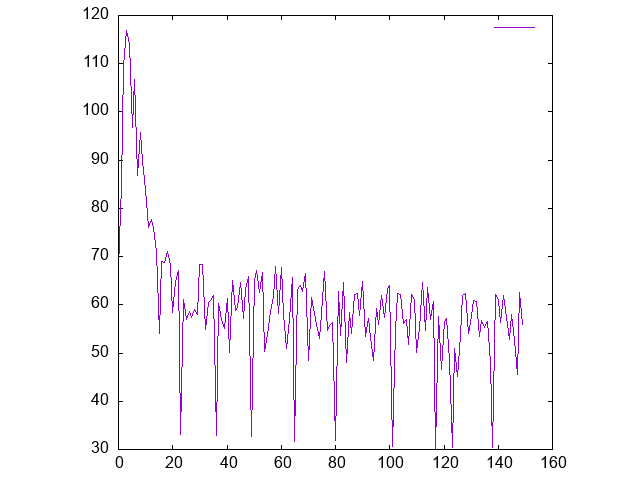

In [21]:
(defparameter *imgpath* "./tmp/Seq2Seq_KFTT_Losses.png")

; Lossのx軸の向きは反対
(plot (reverse losses) :output *imgpath*)
(jupyter:file *imgpath* :display t)
; Lossが近辺で停滞しちゃう・・・多分学習データが偏ってる